# SLAB benchmark analysis


In this notebook, I retrieve the results from a [lkp-tests](https://github.com/intel/lkp-tests) benchmark and process the `slabinfo` file in it.

**Benchmark name:** `fsmark-1hdd-1HDD-9B-ext4-1x-16d-256fpd-32t-fsyncBeforeClose-400M.yaml`

**NOTE:** The specs of the VM (used to run the benchmark) is attached at the end of this notebook.

## How the efficiency was calculated


The efficiency means how much space the used objects need in principle, divided by the real memory usage.

> efficiency_in_percent = (num_objs * objsize * 100) / (num_slabs * (page_size * 2 ** order))

The efficiency is calculated individually for each slab cache seperatedly in time.

Taken from [linux/tools/vm/slabinfo.c](https://github.com/torvalds/linux/blob/8a8c600de5dc1d9a7f4b83269fddc80ebd3dd045/tools/vm/slabinfo.c#L644)


## Install instructions

```bash
# or via ssh
git clone --depth 1 https://github.com/intel/lkp-tests

cd lkp-tests
# If this fails, try another OS
sudo make install

cd ..

# Adapt the lkp-tests/hosts/YOUR_HOSTNAME file to have a `hdd_partition` section
# You can use the `create-block-device.sh` script provided in the root of this repository 

# This MUST be done after EVERY change to the "lkp-tests/hosts/YOUR_HOSTNAME" file!
lkp split lkp-tests/jobs/fsmark-1hdd.yaml

sudo lkp install fsmark-1hdd-1HDD-9B-ext4-1x-16d-256fpd-32t-fsyncBeforeClose-400M.yaml
sudo lkp run fsmark-1hdd-1HDD-9B-ext4-1x-16d-256fpd-32t-fsyncBeforeClose-400M.yaml
```

## Result

![Benchmark](images/___lkp___result___fsmark___1HDD-9B-ext4-1x-16d-256fpd-32t-fsyncBeforeClose-400M___david-vm-ubuntu___ubuntu___x86_64-rhel-7.6___gcc-7___5.0.0-31-generic___2.png)

This is a histogram of the efficiencies of ALL slab caches over the whole time.

**NOTE** this is not a weighted histogram, i.e. a small slab cache with 100% efficiency has the same weight as a very big slab cache with only 50% efficiency. So this histogram should be taken with a grain of salt

In [29]:
# Convert this notebook
!jupyter nbconvert --to rst process.ipynb

[NbConvertApp] Converting notebook process.ipynb to rst
[NbConvertApp] Support files will be in process_files/
[NbConvertApp] Making directory process_files
[NbConvertApp] Writing 10706 bytes to process.rst


## Retrieve lkp-tests result folder from VM

In [ ]:
HOST="david-vm-ubuntu"
!mkdir -p results
!mv results/result results/result_`(date +%s)`
!ssh {HOST} 'cd projects; echo "a" | sudo -S ./save_slab_orders.sh'
!scp -r -q {HOST}:projects/result results
!ssh {HOST} 'ls -l projects/result | cut -d ">" -f 2' > results/result/job

## Parse results

In [17]:
import os

FOLDER = 'results/result'
FILE = FOLDER + '/slabinfo'
IMAGE_FOLDER = 'images'

os.makedirs(IMAGE_FOLDER, exist_ok=True)

with open(FOLDER + '/job') as f:
    job_name = f.read().strip()

with open(FILE) as f:
    slab_info = f.read().splitlines()

with open(FOLDER + '/orders') as f:
    orders = {x.split()[0]: int(x.split()[1]) for x in f.readlines()}

# Extracted from `slabinfo`
headers = [
    'time',
    'name',
    'active_objs',
    'num_objs',
    'objsize',
    'objperslab',
    'pagesperslab',
    'tunables',
    'limit',
    'batchcount',
    'sharedfactor',
    'slabdata',
    'active_slabs',
    'num_slabs',
    'sharedavail',
]

def convert_num(x):
    try:
        return int(x)
    except:
        return x

def parse_slabinfo_log(lkp_tests_slab_info):
    data = []
    current = None
    
    for line in slab_info:
        if line.startswith('time:'):
            current = int(line.split()[-1])
            continue
        if line.startswith('# name'):
            continue
        if line.startswith('slabinfo'):
            continue

        l = [current] + [convert_num(x.strip()) for x in line.split() if x is not ':']
        assert len(l) == len(headers)
        data.append(l)
    return data

data = parse_slabinfo_log(slab_info)

## Create visualizations

Test took: 3.13 minutes


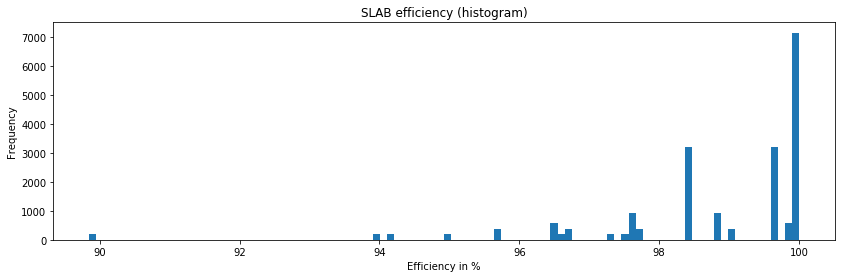

In [20]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data, columns=headers)

#df = df[df.name == 'dentry']

df['order'] = df.name.apply(lambda x: orders.get(x, 0))
df['page_size'] = 4096

df['active_vs_num'] = df.active_objs / df.num_objs

df['ef'] = df.num_objs * df.objsize * 100 / (df.num_slabs * (df.page_size * 2 ** df.order))

ax = df.ef.plot(kind='hist', bins=100, figsize=(14, 4))

ax.set_title(f'SLAB efficiency (histogram)')
ax.set_xlabel('Efficiency in %')

def sanitize_name(x):
    return x.replace('/', '___')

plt.savefig(f'{IMAGE_FOLDER}/{sanitize_name(job_name)}.png')

duration_in_seconds = max(df.time.values) - min(df.time.values)
print(f'Test took: {duration_in_seconds / 60:.2f} minutes')

In [13]:
job_name

'/lkp/result/fsmark/1HDD-9B-ext4-1x-16d-256fpd-32t-fsyncBeforeClose-400M/david-vm-ubuntu/ubuntu/x86_64-rhel-7.6/gcc-7/5.0.0-31-generic/2'

## VM specs

**uname -a**: Linux david-vm-ubuntu 5.0.0-31-generic #33~18.04.1-Ubuntu SMP Tue Oct 1 10:20:39 UTC 2019 x86_64 x86_64 x86_64 GNU/Linux

<pre>
Name:                        Ubuntu
Groups:                      /
Guest OS:                    Ubuntu (64-bit)
UUID:                        517d91b9-e324-470f-b1f3-dcaf40f3ab01
Config file:                 /home/dgengenbach/VirtualBox VMs/Ubuntu/Ubuntu.vbox
Snapshot folder:             /home/dgengenbach/VirtualBox VMs/Ubuntu/Snapshots
Log folder:                  /home/dgengenbach/VirtualBox VMs/Ubuntu/Logs
Hardware UUID:               517d91b9-e324-470f-b1f3-dcaf40f3ab01
Memory size                  16384MB
Page Fusion:                 disabled
VRAM size:                   16MB
CPU exec cap:                100%
HPET:                        disabled
CPUProfile:                  host
Chipset:                     piix3
Firmware:                    BIOS
Number of CPUs:              4
PAE:                         disabled
Long Mode:                   enabled
Triple Fault Reset:          disabled
APIC:                        enabled
X2APIC:                      enabled
Nested VT-x/AMD-V:           disabled
CPUID Portability Level:     0
CPUID overrides:             None
Boot menu mode:              message and menu
Boot Device 1:               Floppy
Boot Device 2:               DVD
Boot Device 3:               HardDisk
Boot Device 4:               Not Assigned
ACPI:                        enabled
IOAPIC:                      enabled
BIOS APIC mode:              APIC
Time offset:                 0ms
RTC:                         UTC
Hardw. virt.ext:             enabled
Nested Paging:               enabled
Large Pages:                 disabled
VT-x VPID:                   enabled
VT-x unr. exec.:             enabled
Paravirt. Provider:          Default
Effective Paravirt. Prov.:   KVM
State:                       running (since 2019-10-10T10:10:24.186000000)
Monitor count:               1
3D Acceleration:             disabled
2D Video Acceleration:       disabled
Teleporter Enabled:          disabled
Teleporter Port:             0
Teleporter Address:          
Teleporter Password:         
Tracing Enabled:             disabled
Allow Tracing to Access VM:  disabled
Tracing Configuration:       
Autostart Enabled:           disabled
Autostart Delay:             0
Default Frontend:            
Storage Controller Name (0):            IDE
Storage Controller Type (0):            PIIX4
Storage Controller Instance Number (0): 0
Storage Controller Max Port Count (0):  2
Storage Controller Port Count (0):      2
Storage Controller Bootable (0):        on
Storage Controller Name (1):            SATA
Storage Controller Type (1):            IntelAhci
Storage Controller Instance Number (1): 0
Storage Controller Max Port Count (1):  30
Storage Controller Port Count (1):      1
Storage Controller Bootable (1):        on
IDE (1, 0): Empty
SATA (0, 0): /home/dgengenbach/VirtualBox VMs/Ubuntu/Ubuntu.vdi (UUID: 466e9eb9-b4f4-4088-9a6f-fc60775b5c8c)
NIC 1:                       MAC: 080027CA5503, Attachment: Bridged Interface 'eno1', Cable connected: on, Trace: off (file: none), Type: 82540EM, Reported speed: 0 Mbps, Boot priority: 0, Promisc Policy: deny, Bandwidth group: none
NIC 2:                       disabled
NIC 3:                       disabled
NIC 4:                       disabled
NIC 5:                       disabled
NIC 6:                       disabled
NIC 7:                       disabled
NIC 8:                       disabled
Pointing Device:             USB Tablet
Keyboard Device:             PS/2 Keyboard
UART 1:                      disabled
UART 2:                      disabled
UART 3:                      disabled
UART 4:                      disabled
LPT 1:                       disabled
LPT 2:                       disabled
Audio:                       enabled (Driver: PulseAudio, Controller: AC97, Codec: AD1980)
Audio playback:              enabled
Audio capture:               disabled
Clipboard Mode:              disabled
Drag and drop Mode:          disabled
Session name:                headless
Video mode:                  800x600x32 at 0,0 enabled
VRDE:                        disabled
OHCI USB:                    enabled
EHCI USB:                    disabled
xHCI USB:                    disabled

USB Device Filters:

<none>

Available remote USB devices:

<none>

Currently Attached USB Devices:

<none>

Bandwidth groups:  <none>

Shared folders:<none>

VRDE Connection:             not active
Clients so far:              0

Capturing:                   not active
Capture audio:               not active
Capture screens:             0
Capture file:                /home/dgengenbach/VirtualBox VMs/Ubuntu/Ubuntu.webm
Capture dimensions:          1024x768
Capture rate:                512kbps
Capture FPS:                 25kbps
Capture options:             

Guest:

Configured memory balloon size: 0MB
OS type:                     Linux26_64
Additions run level:         1
Additions version            6.0.6_KernelUbuntu r129722

Guest Facilities:

Facility "VirtualBox Base Driver": active/running (last update: 2019/10/10 10:10:31 UTC)
Facility "Seamless Mode": not active (last update: 2019/10/10 10:10:31 UTC)
Facility "Graphics Mode": not active (last update: 2019/10/10 10:10:31 UTC)
</pre>